<a href="https://colab.research.google.com/github/maxkond1/KP/blob/main/%D0%9A%D0%9F_%D0%98%D0%9D%D0%A1_%D0%9A%D0%BE%D0%BD%D0%B4%D0%B8%D1%82%D0%B5%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kagglehub[pandas-datasets] transformers torch pandas scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from transformers import BertTokenizer, BertForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import gc
from datasets import Dataset as HFDataset
import numpy as np

In [ ]:
# Кастомный класс для датасета
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# 1. Загрузка токенизатора и модели для классификации (без дообучения)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 2. Загрузка данных IMDB Dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "IMDB Dataset.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews",
  file_path
)

print("First 5 records:", df.head())

<ipython-input-5-25411a17ea03>:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Очистка тегов <br /><br /> и приведение к нижнему регистру
df['review'] = df['review'].str.replace('<br /><br />', ' ', regex=False).str.lower()
print("First 5 records (после очистки):", df.head())

First 5 records (после очистки):                                               review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production.  the filming te...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically there's a family where a little boy ...  negative
4  petter mattei's "love in the time of money" is...  positive


In [ ]:
# Определение столбцов
texts = df['review'].tolist()  # Столбец с отзывами
labels = df['sentiment'].map({'positive': 1, 'negative': 0}).tolist()  # Преобразуем в 0 и 1

In [ ]:
# Ограничим выборку до 5000 текстов для скорости
if len(texts) > 5000:
    df = df.sample(n=5000, random_state=42)
    texts = df['review'].tolist()
    labels = df['sentiment'].map({'positive': 1, 'negative': 0}).tolist()

In [ ]:
# Разбиение реальных данных
train_texts_real, val_texts_real, train_labels_real, val_labels_real = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

In [ ]:
# 3. Генерация синтетических отзывов с улучшенными промптами
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
generator_model = GPT2LMHeadModel.from_pretrained('gpt2')
generator_model.to(device)
generator_model.eval()

# Улучшенные промпты с вариациями
prompts = [
    "this film offers a unique experience",
    "the movie captures emotions in a way that",
    "an incredible story unfolds with",
    "i felt mixed about this film because",
    "the direction in this movie",
    "this cinematic journey left me",
    "a remarkable production featuring",
    "the visuals of this film",
    "i was captivated by how",
    "this picture struggles with"
]

synthetic_texts = []
target_size = 2000
texts_per_prompt = target_size // len(prompts)

for prompt in prompts:
    for _ in range(texts_per_prompt):
        input_ids = generator_tokenizer.encode(prompt, return_tensors="pt").to(device)
        # Случайное сочетание параметров для разнообразия
        output = generator_model.generate(
            input_ids,
            max_length=50,
            num_return_sequences=8,
            temperature=np.random.uniform(0.7, 1.0),
            top_k=np.random.randint(40, 60),
            top_p=0.95,
            do_sample=True,
            no_repeat_ngram_size=2  # Избегаем повторения n-грамм
        )
        synthetic_texts.extend([generator_tokenizer.decode(o, skip_special_tokens=True) for o in output.cpu()])

synthetic_texts = [text for text in synthetic_texts if not any(keyword in text.lower() for keyword in ["advertisement", "avc", "tv cameras"])]
synthetic_texts = synthetic_texts[:2000]
synthetic_labels = [1 if i % 2 == 0 else 0 for i in range(len(synthetic_texts))]
synthetic_labels_str = ['positive' if label == 1 else 'negative' for label in synthetic_labels]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask

In [ ]:
# Сохранение синтетических данных
synthetic_df = pd.DataFrame({
    'review': synthetic_texts,
    'sentiment': synthetic_labels_str
})
synthetic_df.to_csv('synthetic_reviews.csv', index=False)

In [ ]:
print("\nСодержимое файла synthetic_reviews.csv (первые 5 записей):")
synthetic_df_read = pd.read_csv('synthetic_reviews.csv')
print(synthetic_df_read.head())


Содержимое файла synthetic_reviews.csv (первые 5 записей):
                                              review sentiment
0  this film offers a unique experience as it fol...  positive
1  this film offers a unique experience, and a ve...  negative
2  this film offers a unique experience that allo...  positive
3  this film offers a unique experience.\n\nThe f...  negative
4  this film offers a unique experience that will...  positive


In [ ]:
# Разбиение синтетических данных
train_texts_synth, val_texts_synth, train_labels_synth, val_labels_synth = train_test_split(
    synthetic_texts, synthetic_labels, test_size=0.2, stratify=synthetic_labels, random_state=42
)

In [ ]:
# 4. Комбинирование датасетов
combined_texts = train_texts_real + train_texts_synth
combined_labels = train_labels_real + train_labels_synth
combined_texts_val = val_texts_real + val_texts_synth
combined_labels_val = val_labels_real + val_labels_synth

In [ ]:
# Разбиение комбинированного набора
train_texts_comb, val_texts_comb, train_labels_comb, val_labels_comb = train_test_split(
    combined_texts, combined_labels, test_size=0.2, stratify=combined_labels, random_state=42
)

In [ ]:
# Вывод комбинированного набора
combined_labels_str = ['positive' if label == 1 else 'negative' for label in val_labels_comb]
combined_df = pd.DataFrame({
    'review': val_texts_comb,
    'sentiment': combined_labels_str
})
print("\nСодержимое комбинированного набора (первые 5 записей):")
print(combined_df.head())


Содержимое комбинированного набора (первые 5 записей):
                                              review sentiment
0  i just cant see what everyone sees in this mov...  negative
1  this film offers a unique experience of the hu...  positive
2  i just finished "dark chamber" aka "under surv...  negative
3  big s isn't playing with taboos or forcing an ...  positive
4  this film offers a unique experience of Americ...  negative


In [ ]:
# 5. Оценка без дообучения
model.to(device)
model.eval()

def evaluate_model(model, texts, labels):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    dataset = IMDBDataset(encodings, labels)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            preds = torch.softmax(outputs.logits, dim=1).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1

val_accuracy_real, val_f1_real = evaluate_model(model, val_texts_real, val_labels_real)
val_accuracy_synth, val_f1_synth = evaluate_model(model, val_texts_synth, val_labels_synth)
val_accuracy_comb, val_f1_comb = evaluate_model(model, val_texts_comb, val_labels_comb)

print(f"\nМетрики на реальных данных (без дообучения): Точность: {val_accuracy_real:.2f}, F1-score: {val_f1_real:.2f}")
print(f"Метрики на синтетических данных (без дообучения): Точность: {val_accuracy_synth:.2f}, F1-score: {val_f1_synth:.2f}")
print(f"Метрики на комбинированном наборе (без дообучения): Точность: {val_accuracy_comb:.2f}, F1-score: {val_f1_comb:.2f}")


Метрики на реальных данных (без дообучения): Точность: 0.48, F1-score: 0.38
Метрики на синтетических данных (без дообучения): Точность: 0.49, F1-score: 0.43
Метрики на комбинированном наборе (без дообучения): Точность: 0.49, F1-score: 0.39


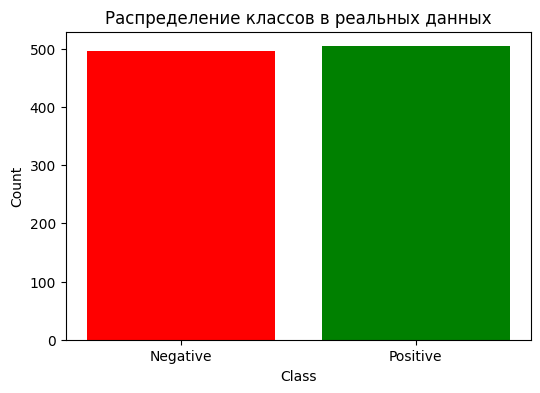

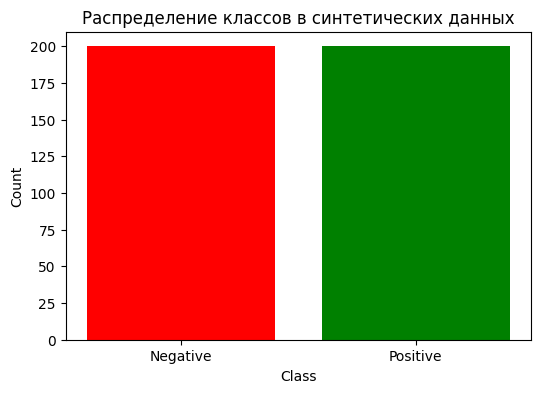

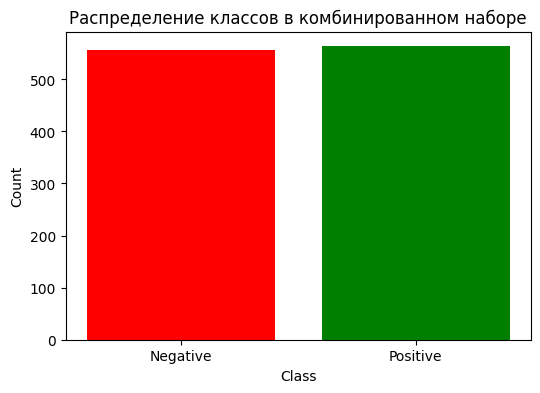

In [ ]:
# 6. Визуализация частотного распределения
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(['Negative', 'Positive'], counts, color=['red', 'green'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(val_labels_real, 'Распределение классов в реальных данных')
plot_class_distribution(val_labels_synth, 'Распределение классов в синтетических данных')
plot_class_distribution(val_labels_comb, 'Распределение классов в комбинированном наборе')

In [ ]:
from transformers import __version__
print(__version__)

4.52.2


In [ ]:
# 7. Дообучение моделей
def prepare_hf_dataset(texts, labels):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    dataset = HFDataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })
    return dataset

train_dataset_real = prepare_hf_dataset(train_texts_real, train_labels_real)
val_dataset_real = prepare_hf_dataset(val_texts_real, val_labels_real)

train_dataset_synth = prepare_hf_dataset(train_texts_synth, train_labels_synth)
val_dataset_synth = prepare_hf_dataset(val_texts_synth, val_labels_synth)

train_dataset_comb = prepare_hf_dataset(train_texts_comb, train_labels_comb)
val_dataset_comb = prepare_hf_dataset(val_texts_comb, val_labels_comb)

# Проверка версии и настройка TrainingArguments
from transformers import __version__ as transformers_version
print(f"Transformers version: {transformers_version}")

# Используем eval_strategy вместо evaluation_strategy
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",       # Заменено с evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
)

def train_model(train_dataset, val_dataset, model_name):
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    trainer.train()
    return model

print("\nДообучение на реальных данных...")
model_real = train_model(train_dataset_real, val_dataset_real, "real")
print("Дообучение на синтетических данных...")
model_synth = train_model(train_dataset_synth, val_dataset_synth, "synth")
print("Дообучение на комбинированном наборе...")
model_comb = train_model(train_dataset_comb, val_dataset_comb, "comb")

Transformers version: 4.52.2

Дообучение на реальных данных...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maximkonditerov1 (maximkonditerov1-nmstu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.445200,0.402364
2,0.330700,0.353541
3,0.093900,0.545762


Дообучение на синтетических данных...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.690100,0.696718
2,0.708200,0.706943
3,0.662000,0.744642


Дообучение на комбинированном наборе...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.512500,0.451654
2,0.448400,0.430266
3,0.304900,0.537105


In [ ]:
# 8. Оценка дообученных моделей
val_accuracy_real_trained, val_f1_real_trained = evaluate_model(model_real, val_texts_real, val_labels_real)
val_accuracy_synth_trained, val_f1_synth_trained = evaluate_model(model_synth, val_texts_synth, val_labels_synth)
val_accuracy_comb_trained, val_f1_comb_trained = evaluate_model(model_comb, val_texts_comb, val_labels_comb)

# Вывод результатов
print(f"\nМетрики на реальных данных (после дообучения): Точность: {val_accuracy_real_trained:.2f}, F1-score: {val_f1_real_trained:.2f}")
print(f"Метрики на синтетических данных (после дообучения): Точность: {val_accuracy_synth_trained:.2f}, F1-score: {val_f1_synth_trained:.2f}")
print(f"Метрики на комбинированном наборе (после дообучения): Точность: {val_accuracy_comb_trained:.2f}, F1-score: {val_f1_comb_trained:.2f}")


Метрики на реальных данных (после дообучения): Точность: 0.84, F1-score: 0.85
Метрики на синтетических данных (после дообучения): Точность: 0.49, F1-score: 0.46
Метрики на комбинированном наборе (после дообучения): Точность: 0.77, F1-score: 0.77


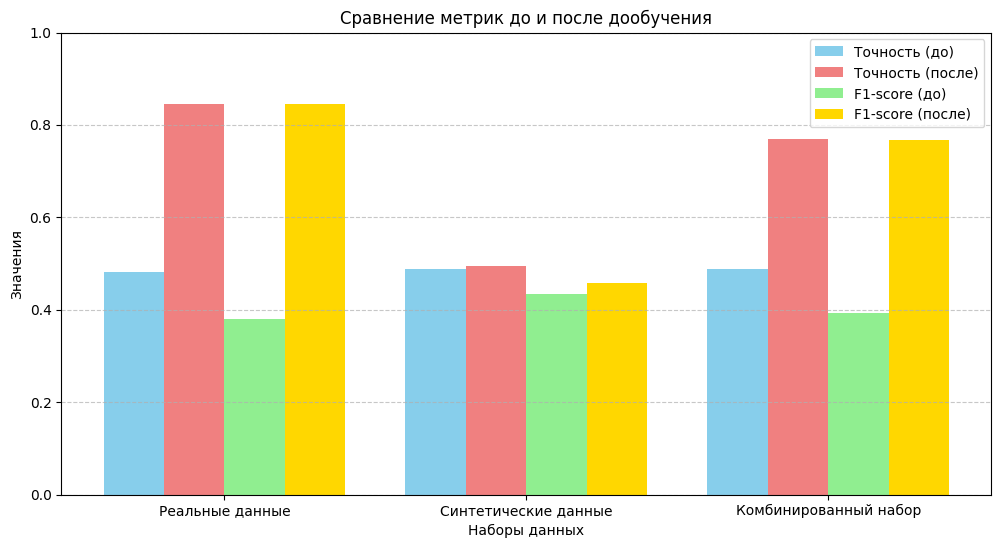

In [ ]:
# 9. Визуализация сравнения метрик
datasets = ['Реальные данные', 'Синтетические данные', 'Комбинированный набор']
accuracies_before = [val_accuracy_real, val_accuracy_synth, val_accuracy_comb]
f1_scores_before = [val_f1_real, val_f1_synth, val_f1_comb]
accuracies_after = [val_accuracy_real_trained, val_accuracy_synth_trained, val_accuracy_comb_trained]
f1_scores_after = [val_f1_real_trained, val_f1_synth_trained, val_f1_comb_trained]

plt.figure(figsize=(12, 6))
bar_width = 0.2
index = range(len(datasets))

plt.bar(index, accuracies_before, bar_width, label='Точность (до)', color='skyblue')
plt.bar([i + bar_width for i in index], accuracies_after, bar_width, label='Точность (после)', color='lightcoral')
plt.bar([i + 2 * bar_width for i in index], f1_scores_before, bar_width, label='F1-score (до)', color='lightgreen')
plt.bar([i + 3 * bar_width for i in index], f1_scores_after, bar_width, label='F1-score (после)', color='gold')

plt.xlabel('Наборы данных')
plt.ylabel('Значения')
plt.title('Сравнение метрик до и после дообучения')
plt.xticks([i + 1.5 * bar_width for i in index], datasets)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()